In [1]:
import pandas as pd
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from collections import Counter
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from stop_words import get_stop_words
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

import string
from string import punctuation
string.punctuation += '-—«»—…–“”'

import pkg_resources
from symspellpy.symspellpy import SymSpell

from tqdm import tqdm

## Exploratory Data Analysis (EDA)

In [2]:
data = pd.read_csv('complaints-2021-06-07_13_47.csv', encoding = 'utf-8', low_memory=False)

In [12]:
data

Date received                                            Product  \
0            03/27/19                                       Student loan   
1            07/31/19  Credit reporting, credit repair services, or o...   
2            04/23/19                                    Debt collection   
3            10/09/19                                    Debt collection   
4            06/28/19  Credit reporting, credit repair services, or o...   
...               ...                                                ...   
1738539      01/02/19                                           Mortgage   
1738540      03/04/19                                           Mortgage   
1738541      01/09/19                              Vehicle loan or lease   
1738542      04/02/19          Payday loan, title loan, or personal loan   
1738543      01/22/17                                       Student loan   

                            Sub-product  \
0        Federal student loan servicing   
1                      Credit reporting   
2             Federal student loan debt   
3                         I do not know   
4                      Credit reporting   
...                                 ...   
1738539          Other type of mortgage   
1738540      Conventional home mortgage   
1738541                            Loan   
1738542                Installment loan   
1738543  Federal student loan servicing   

                                                     Issue  \
0                     Dealing with your lender or servicer   
1                              Improper use of your report   
2                       False statements or representation   
3                        Attempts to collect debt not owed   
4        Problem with a credit reporting company's inve...   
...                                                    ...   
1738539                         Struggling to pay mortgage   
1738540                     Trouble during payment process   
1738541                         Managing the loan or lease   
1738542                        Struggling to pay your loan   
1738543                 Dealing with my lender or servicer   

                                                 Sub-issue  \
0              Trouble with how payments are being handled   
1        Credit inquiries on your report that you don't...   
2                        Attempted to collect wrong amount   
3                                        Debt is not yours   
4        Their investigation did not fix an error on yo...   
...                                                    ...   
1738539                                               None   
1738540                                               None   
1738541                                    Billing problem   
1738542                                               None   
1738543            Need information about my balance/terms   

                              Consumer complaint narrative  \
0                                                      NaN   
1        XXXX Inquiry I did not authorize from XX/XX/19...   
2        I received a letter from XXXX dated XX/XX/19 s...   
3        XX/XX/2019 Cavalry portfolio services called a...   
4                                                      NaN   
...                                                    ...   
1738539                                                NaN   
1738540                                                NaN   
1738541                                                NaN   
1738542                                                NaN   
1738543  My loans have an extraordinarily high interest...   

                                   Company public response  \
0                                                     None   
1        Company has responded to the consumer and the ...   
2                                                     None   
3                                                     None   
4        Company has responded to

Сделаем копию датасета с нужными столбцами.

In [6]:
data = data[['Product', 'Consumer complaint narrative']].copy()

Удалим строки с NaN.

In [7]:
data = data[pd.notnull(data['Consumer complaint narrative'])].reset_index(drop=True)

In [8]:
data

Product  \
0       Credit reporting, credit repair services, or o...   
1                                         Debt collection   
2                                         Debt collection   
3                             Credit card or prepaid card   
4                                         Debt collection   
...                                                   ...   
649635                              Vehicle loan or lease   
649636                              Vehicle loan or lease   
649637                                           Mortgage   
649638                                    Debt collection   
649639                                       Student loan   

                             Consumer complaint narrative  
0       XXXX Inquiry I did not authorize from XX/XX/19...  
1       I received a letter from XXXX dated XX/XX/19 s...  
2       XX/XX/2019 Cavalry portfolio services called a...  
3       XX/XX/2019 made a purchase of 2 motorcycles fi...  
4       I am writing again about Ace Cash Express debt...  
...                                                   ...  
649635  I leased a car through XXXX XXXX and terminate...  
649636  I lease a XXXX  XXXX XXXX through the Fair app...  
649637  XX/XX/2019, I spoke with XXXX in the escrow de...  
649638  Today, XX/XX/2019, I received a call from Sout...  
649639  My loans have an extraordinarily high interest...  

[649640 rows x 2 columns]

Посмотрим, сколько всего жалоб в каждой категории.

In [9]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    271952
Debt collection                                                                 143410
Mortgage                                                                         79218
Credit card or prepaid card                                                      54591
Checking or savings account                                                      32457
Student loan                                                                     28302
Money transfer, virtual currency, or money service                               15088
Vehicle loan or lease                                                            13378
Payday loan, title loan, or personal loan                                         9498
Payday loan                                                                       1746
Name: Product, dtype: int64

Объединим повторяющиеся категории в одну.

In [10]:
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'

Оставим строки с заданной длиной.

In [11]:
data = data[data['Consumer complaint narrative'].str.len().between(50, 5000)]

In [12]:
data

Product  \
0       Credit reporting, credit repair services, or o...   
1                                         Debt collection   
2                                         Debt collection   
3                             Credit card or prepaid card   
4                                         Debt collection   
...                                                   ...   
649634                                    Debt collection   
649635                              Vehicle loan or lease   
649636                              Vehicle loan or lease   
649637                                           Mortgage   
649639                                       Student loan   

                             Consumer complaint narrative  
0       XXXX Inquiry I did not authorize from XX/XX/19...  
1       I received a letter from XXXX dated XX/XX/19 s...  
2       XX/XX/2019 Cavalry portfolio services called a...  
3       XX/XX/2019 made a purchase of 2 motorcycles fi...  
4       I am writing again about Ace Cash Express debt...  
...                                                   ...  
649634  I just recently married my husband and I am tr...  
649635  I leased a car through XXXX XXXX and terminate...  
649636  I lease a XXXX  XXXX XXXX through the Fair app...  
649637  XX/XX/2019, I spoke with XXXX in the escrow de...  
649639  My loans have an extraordinarily high interest...  

[633883 rows x 2 columns]

Отбросим дубликаты.

In [13]:
data = data.drop_duplicates(subset=['Consumer complaint narrative'], keep='first').reset_index(drop=True)

In [14]:
data.describe()

Product  \
count                                              572941   
unique                                                  9   
top     Credit reporting, credit repair services, or o...   
freq                                               211595   

                             Consumer complaint narrative  
count                                              572941  
unique                                             572941  
top     I have been paying on my medical bills to Midw...  
freq                                                    1

Удалим строки со слившимися словами.

In [17]:
data[data['Consumer complaint narrative'].str.contains('insurancecompanypowerofattorneytocompletetherestofthepaperwork')]

Product  \
214745  Vehicle loan or lease   

                             Consumer complaint narrative  
214745  OnXX/XX/XXXX,Iwasinvolvedinacaraccident(atnofa...

In [18]:
data['Consumer complaint narrative'][214745]

'OnXX/XX/XXXX,Iwasinvolvedinacaraccident(atnofaultofmyown)andmyvehiclewasdeterminedtobeatotallossbytheotherparty\'sinsurancecompany.Iwasinstructedbytheinsurancecompanytosurrenderthekeys,vehicle,registration,etc.Isignedlegaldocumentsthatwerenotarizedgivingtheotherparty\'sinsurancecompanypowerofattorneytocompletetherestofthepaperwork.\nIcontactedSantandertoinformthemoftheaccidentandtheotherparty\'sinsurancecompanyalsocontactedSantandernumeroustimes.OnetimethattheycontactedSantander,Irequestedtobeonholdtoensurethatcontactwasmade.TherepresentativeverifiedthattheymadecontactwithSantander.\nOnXX/XX/XXXX,IreceivedaTotalLossLetterfromtheotherparty\'sinsurancecompanyshowing,infact,thatthecarwasatotallossandtheyarepayingout{$21000.00}toSantanderConsumer.\nSincethen,SantanderConsumerhasinaccuratelyreportedonmycreditreportthatIhavebeenlate,chargedoffmyaccountstating,"chargedoffasbaddebt/profitandlosswriteoff\'\',closedmyaccountonXX/XX/XXXXandsaysthatIhaveabalanceof{$26000.00}.Santanderevensentarep

In [19]:
words = data['Consumer complaint narrative'].values.tolist()

In [20]:
words2 = [i.split() for i in words]

In [21]:
long_words_lst = [' '.join([word for word in i if len(word)> 17]) for i in words2]

In [22]:
long_words_lst

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'CapitalOneallowedadatabreachthatXXXXhavedistributedmymostpersonalfinancialandidentificationinformation.',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'tremendously..CFPB',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'XX/XX/XXXXSantander',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'XX/XX/XXXX-XX/XX/XXXX.',
 '',
 '',
 '',
 '',
 'unresponsive.Moreover, silence.Statebridge',
 '',
 '',
 '',
 '',
 '',
 '',
 'XX/XX/XXXX/XX/XX/2019',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'requested/required',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'XX/XX/XXXXXX/XX/XXXXand',
 'XX/XX/XXXX-XX/XX/XXXX',
 '',
 ''

In [23]:
data['long_words_lst'] = long_words_lst

In [25]:
data=data[data['long_words_lst'] ==''].reset_index(drop=True)

In [24]:
data

Product  \
0       Credit reporting, credit repair services, or o...   
1                                         Debt collection   
2                                         Debt collection   
3                             Credit card or prepaid card   
4                                         Debt collection   
...                                                   ...   
572936                                    Debt collection   
572937                              Vehicle loan or lease   
572938                              Vehicle loan or lease   
572939                                           Mortgage   
572940                                       Student loan   

                             Consumer complaint narrative long_words_lst  
0       XXXX Inquiry I did not authorize from XX/XX/19...                 
1       I received a letter from XXXX dated XX/XX/19 s...                 
2       XX/XX/2019 Cavalry portfolio services called a...                 
3       XX/XX/2019 made a purchase of 2 motorcycles fi...                 
4       I am writing again about Ace Cash Express debt...                 
...                                                   ...            ...  
572936  I just recently married my husband and I am tr...                 
572937  I leased a car through XXXX XXXX and terminate...                 
572938  I lease a XXXX  XXXX XXXX through the Fair app...                 
572939  XX/XX/2019, I spoke with XXXX in the escrow de...                 
572940  My loans have an extraordinarily high interest...                 

[572941 rows x 3 columns]

In [26]:
data

Product  \
0       Credit reporting, credit repair services, or o...   
1                                         Debt collection   
2                                         Debt collection   
3                             Credit card or prepaid card   
4                                         Debt collection   
...                                                   ...   
545197                                    Debt collection   
545198                              Vehicle loan or lease   
545199                              Vehicle loan or lease   
545200                                           Mortgage   
545201                                       Student loan   

                             Consumer complaint narrative long_words_lst  
0       XXXX Inquiry I did not authorize from XX/XX/19...                 
1       I received a letter from XXXX dated XX/XX/19 s...                 
2       XX/XX/2019 Cavalry portfolio services called a...                 
3       XX/XX/2019 made a purchase of 2 motorcycles fi...                 
4       I am writing again about Ace Cash Express debt...                 
...                                                   ...            ...  
545197  I just recently married my husband and I am tr...                 
545198  I leased a car through XXXX XXXX and terminate...                 
545199  I lease a XXXX  XXXX XXXX through the Fair app...                 
545200  XX/XX/2019, I spoke with XXXX in the escrow de...                 
545201  My loans have an extraordinarily high interest...                 

[545202 rows x 3 columns]

In [27]:
data[data['Consumer complaint narrative'].str.contains('insurancecompanypowerofattorneytocompletetherestofthepaperwork')]

Empty DataFrame
Columns: [Product, Consumer complaint narrative, long_words_lst]
Index: []

Подсчитаем количество жалоб в каждой категории и визуализируем данные.

In [28]:
count_by_product = data['Product'].groupby(data['Product']) \
                              .count() \
                              .reset_index(name='Number of complaints') \
                              .sort_values(['Number of complaints'], ascending=False)

In [29]:
count_by_product

Product  Number of complaints
2  Credit reporting, credit repair services, or o...                201023
3                                    Debt collection                129600
5                                           Mortgage                 71885
1                        Credit card or prepaid card                 49891
0                        Checking or savings account                 30117
7                                       Student loan                 26019
4  Money transfer, virtual currency, or money ser...                 13861
8                              Vehicle loan or lease                 12271
6          Payday loan, title loan, or personal loan                 10535

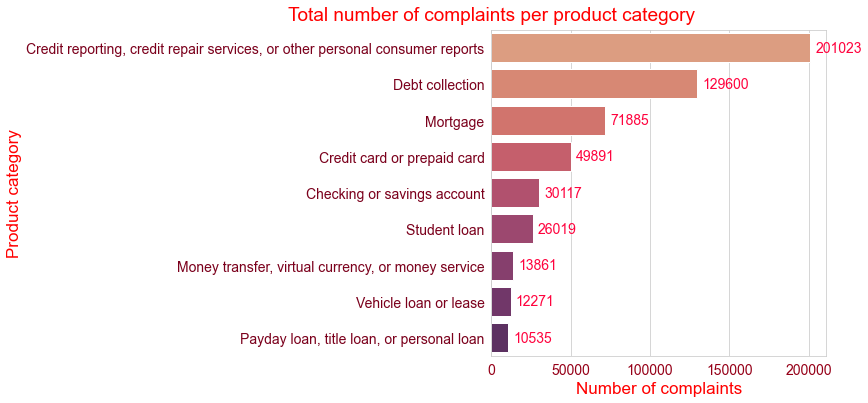

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=count_by_product.sort_values('Number of complaints', ascending=False), x='Number of complaints', y='Product', palette = "flare")
ax.tick_params(axis="y", labelsize=14, labelcolor = '#7B001C')
ax.tick_params(axis="x", labelsize=14, labelcolor = '#960018')
plt.title("Total number of complaints per product category", fontsize=19, color = 'Red', x = 0, y = 1.01)
plt.xlabel('Number of complaints', fontsize=17, color = 'Red')
plt.ylabel('Product category', fontsize=17, color = 'Red')

for p in ax.patches:
     ax.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", color = "#FF033E", fontsize=14)
plt.show()

Уменьшим количество жалоб в каждой категории до максимального значения 10535.

In [31]:
M = 190488
mask = (data['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports')
df = data[(mask.cumsum() > M) | ~mask]

In [32]:
M = 119065
mask2 = (df['Product'] == 'Debt collection')
df = df[(mask2.cumsum() > M) | ~mask2]

In [33]:
M = 61350
mask3= (df['Product'] == 'Mortgage')
df = df[(mask3.cumsum() > M) | ~mask3]

In [34]:
M = 39356
mask4 = (df['Product'] == 'Credit card or prepaid card')
df = df[(mask4.cumsum() > M) | ~mask4]

In [35]:
M = 19582
mask5 = (df['Product'] == 'Checking or savings account')
df = df[(mask5.cumsum() > M) | ~mask5]

In [36]:
M = 15484
mask6 = (df['Product'] == 'Student loan')
df = df[(mask6.cumsum() > M) | ~mask6]

In [37]:
M = 3326
mask7 = (df['Product'] == 'Money transfer, virtual currency, or money service')
df = df[(mask7.cumsum() > M) | ~mask7]

In [38]:
M = 1736
mask8 = (df['Product'] == 'Vehicle loan or lease')
df = df[(mask8.cumsum() > M) | ~mask8]

In [39]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    10535
Money transfer, virtual currency, or money service                              10535
Debt collection                                                                 10535
Student loan                                                                    10535
Checking or savings account                                                     10535
Vehicle loan or lease                                                           10535
Payday loan, title loan, or personal loan                                       10535
Mortgage                                                                        10535
Credit card or prepaid card                                                     10535
Name: Product, dtype: int64

In [40]:
data = df.sample(frac=1).reset_index(drop='True')

In [41]:
data

Product  \
0      Money transfer, virtual currency, or money ser...   
1                            Credit card or prepaid card   
2                            Checking or savings account   
3      Money transfer, virtual currency, or money ser...   
4                                  Vehicle loan or lease   
...                                                  ...   
94810                        Checking or savings account   
94811                                           Mortgage   
94812                              Vehicle loan or lease   
94813                                           Mortgage   
94814                                       Student loan   

                            Consumer complaint narrative long_words_lst  
0      Coin base refuses to change my email address t...                 
1      Capital One Bank has not resolved or attempted...                 
2      On XX/XX/2018 I traveled to XXXX. I remained i...                 
3      Hi, On XXXX XXXX fraud transactions ( XXXX tra...                 
4      We pay extra every month on a car loan that we...                 
...                                                  ...            ...  
94810  I opened an account with BOA, which I had in g...                 
94811  my wife had 3 XXXX  XXXX in 2 years. i got lai...                 
94812  This complaint is related to GM Financial XXXX...                 
94813  My situation dates back many years to dealings...                 
94814  I have 3 issues : 1. I have been on an income ...                 

[94815 rows x 3 columns]

In [53]:
data['Consumer complaint narrative'][1]

'Capital One Bank has not resolved or attempted to resolve the issues detailed in my letters or in my numerous calls with Capital One customer service specialists and supervisors. Please see attached letters dated XXXX XXXX, XXXX and XXXX XXXX, XXXX. My final attempt to resolve this was through several phone calls in the month of XXXX XXXX with Capital One representatives and supervisors with no attempt to resolve this. My final response from Capital One is that there is nothing they can do. I am demanding all itemized billing statements to prove that I made purchases on this credit card account from XXXX XXXX, XXXX through XXXX XXXX, XXXX. If they can not provide proof that I made these purchases I am demanding that the amount they have no record of as well as interest charges be taken off of my statement. I am requesting that this be resolved after this complaint, as this has been an ongoing dispute and I am paying for these unauthorized charges every month for the past 16 years as w

Посмотрим на облако слов для всего корпуса.

In [43]:
def cloud(text):
    wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS,
                          width=800, height=500, random_state=21, 
                          max_font_size=110).generate(" ".join([i for i in text]))
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

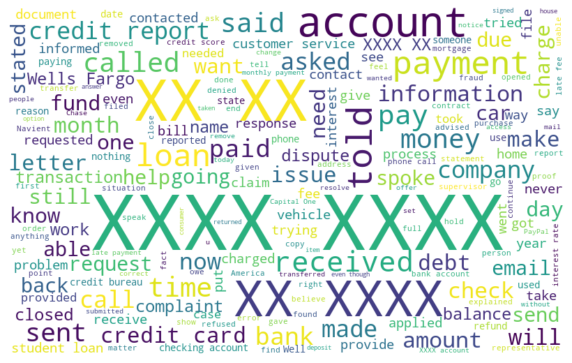

In [43]:
cloud(data['Consumer complaint narrative'])

## Preprocessing

Предобработаем тексты (заменим сокращения на полные формы, удалим пунктуацию, стоп-слова и т.д.).

In [51]:
contraction_dict = {"ain't": "are not", " aint ": " are not ", "aren't": "are not", " cant ": " cannot ", "can't": "cannot", "'cause": "because", ' chk ': ' check ', "could've": "could have", "couldn't": "could not", "couldnt": "could not", "'d ": " would ", "didnt": "did not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "dont": "do not", "doesnt": "does not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", " iVe ": "I have", "Ive": "I have", " im ": " I am ", " Im ": " I am ", "I'm": "I am", "I've": "I have", "Id": "I would", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "'ll": " will ", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", ' mths ': ' months ', "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "n't": " not ", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "'re": " are ", ' rcvd ': ' received ', "'s": " ", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have", "thats": "that is", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "theyre": "they are", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "'ve": " have ", " yrs ": " years "}

In [52]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [55]:
data[data['Consumer complaint narrative'].str.contains("cant")]

Product  \
22             Payday loan, title loan, or personal loan   
26                                          Student loan   
28                           Credit card or prepaid card   
70                                          Student loan   
72                                       Debt collection   
...                                                  ...   
94714                                       Student loan   
94726  Credit reporting, credit repair services, or o...   
94789                                           Mortgage   
94804                        Credit card or prepaid card   
94813                                           Mortgage   

                            Consumer complaint narrative long_words_lst  \
22     I received a check by mail for {$2400.00} and ...                  
26     I paid four of my five student loans in full w...                  
28     Hello, Chase closed all my credit card account...                  
70     I have been trying to work with Navient for th...                  
72     NOTE : I am no liable for this account since m...                  
...                                                  ...            ...   
94714  To keep it short and simple, I have had studen...                  
94726  I am in the middle of a refinance. I have sign...                  
94789  Chase is miss-reporting payments made and rece...                  
94804  I originally opened the account for a MasterCa...                  
94813  My situation dates back many years to dealings...                  

                                Consumer_complaint_clean  
22     I received a check by mail for {$2400.00} and ...  
26     I paid four of my five student loans in full w...  
28     Hello, Chase closed all my credit card account...  
70     I have been trying to work with Navient for th...  
72     NOTE : I am no liable for this account since m...  
...                                                  ...  
94714  To keep it short and simple, I have had studen...  
94726  I am in the middle of a refinance. I have sign...  
94789  Chase is miss-reporting payments made and rece...  
94804  I originally opened the account for a MasterCa...  
94813  My situation dates back many years to dealings...  

[3664 rows x 4 columns]

In [56]:
data['Consumer complaint narrative'][22]

'I received a check by mail for {$2400.00} and I checked in. I was paying regularly my debit but I found myself in a difficult situation and I didnt pay for two months. I woman XXXX, started calling me to my work place almost every day, been so rude and aggressive towards me. I explain to her that she can no longer call to my work place and I has having returned her calls even if she still abusive with me. She called me ones again asking me to my work address and I explained that I can give that to her. She in putting my work in risk with those calls. Im working to have that loan pay, but I cant right now.'

In [57]:
data['Consumer_complaint_clean'] = data['Consumer complaint narrative'].apply(lambda x: replace_contractions(x))

In [58]:
data['Consumer_complaint_clean'][22]

'I received a check by mail for {$2400.00} and I checked in. I was paying regularly my debit but I found myself in a difficult situation and I did not pay for two months. I woman XXXX, started calling me to my work place almost every day, been so rude and aggressive towards me. I explain to her that she can no longer call to my work place and I has having returned her calls even if she still abusive with me. She called me ones again asking me to my work address and I explained that I can give that to her. She in putting my work in risk with those calls. I am working to have that loan pay, but I cannot right now.'

Удалим все ссылки и email адреса.

In [59]:
data[data['Consumer_complaint_clean'].str.contains('http')]

Product  \
216    Money transfer, virtual currency, or money ser...   
365                                         Student loan   
529    Money transfer, virtual currency, or money ser...   
574                                      Debt collection   
2453                               Vehicle loan or lease   
...                                                  ...   
91252  Money transfer, virtual currency, or money ser...   
91632                                       Student loan   
91732                        Credit card or prepaid card   
92974                                    Debt collection   
93397                        Checking or savings account   

                            Consumer complaint narrative long_words_lst  \
216    I received a job offer for a company called XX...                  
365    XXXX - XXXX XXXX. \nXXXX charged {$11000.00} f...                  
529    On XX/XX/2020, I was online looking forward to...                  
574    I received a telephone call on a company phone...                  
2453   Dear Consumer Financial Protection Bureau : Re...                  
...                                                  ...            ...   
91252  XX/XX/2021 This is fraudulent, I have blocked ...                  
91632  To whom it concerns if anyone, I have several ...                  
91732  I was not planning on reporting this- but when...                  
92974  JJ MARSHALL ASSOCIATES INC PRETENDS TO BE LAWY...                  
93397  CITIBANK SOLD THIS ORIGINAL CHECK AS A SECURIT...                  

                                Consumer_complaint_clean  
216    I received a job offer for a company called XX...  
365    XXXX - XXXX XXXX. \nXXXX charged {$11000.00} f...  
529    On XX/XX/2020, I was online looking forward to...  
574    I received a telephone call on a company phone...  
2453   Dear Consumer Financial Protection Bureau : Re...  
...                                                  ...  
91252  XX/XX/2021 This is fraudulent, I have blocked ...  
91632  To whom it concerns if anyone, I have several ...  
91732  I was not planning on reporting this- but when...  
92974  JJ MARSHALL ASSOCIATES INC PRETENDS TO BE LAWY...  
93397  CITIBANK SOLD THIS ORIGINAL CHECK AS A SECURIT...  

[166 rows x 4 columns]

In [60]:
data['Consumer_complaint_clean'][216]

'I received a job offer for a company called XXXX XXXX ( https : XXXX ) on XX/XX/XXXX. XXXX XXXX, who is a HR Coordinator, contacted me to proceed and sent me an employment letter via E-mail XXXX. I found the job on XXXX.XXXX  conducted a job interview through XXXX XXXX  via XXXX. \n\nOn XX/XX/XXXX I received checks from XXXX XXXX to purchase a remote work equipments. \nHe asked me to deposit it on my bank account to purchase the equipments through one of their vendors. So I did so. \n\nOn XX/XX/XXXX, XXXX asked me to send {$2400.00} to XXXX XXXX through XXXX on my Bank of America account. XXXX   phone number is XXXX. \nI made the money transfer as he said. \n\nFinally I found out the information that the checks I have been sent are fake. I immediately contacted a customer support of Bank of America to stop the money transfer since it is still in the process. However they are not helpful to stop the transaction even though I am scammed. They told me that XXXX is an automatic transactio

In [61]:
data[data['Consumer_complaint_clean'].str.contains('trading account on www.')]

Product  \
31391  Money transfer, virtual currency, or money ser...   

                            Consumer complaint narrative long_words_lst  \
31391  From the XXXX XXXX 2017 I have been locked out...                  

                                Consumer_complaint_clean  
31391  From the XXXX XXXX 2017 I have been locked out...

In [62]:
data['Consumer_complaint_clean'][31391]

'From the XXXX XXXX 2017 I have been locked out of my crytocurrency trading account on www.coinbase.com I have tried to contact coinbase to resolve this through email requests only to recieve automated messages and a faint promise of help " soon \'\'. \nFurther attempts to contact coinbase through their support phone line have resulted in nothing after waiting in excess of 4 hours on " hold \'\' to talk to someone. \n\nThis complete lack of service is unacceptable. \n\nAvoid using coinbase if you can.'

In [63]:
def remove_url(text):
    text_without_url = re.sub(r'http[s]?://\S+', ' ', text)
    text_without_url = re.sub(r'http[s]? : //\S+', ' ', text_without_url)
    text_without_url = re.sub(r'http[s]? :', ' ', text_without_url)
    text_without_url = re.sub(r'http[s]?', ' ', text_without_url)
    text_without_url = re.sub(r'//www\.\S+', ' ', text_without_url) 
    text_without_url = re.sub(r'www\.\S+', '', text_without_url)
    text_without_url = re.sub(r'\( i+ \)', '', text_without_url) 
    text_without_url = re.sub(r'\S+\.com', ' ', text_without_url)
    text_without_url = re.sub(r'\S+\.gov', ' ', text_without_url)
    text_without_url = re.sub(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+', ' ', text_without_url)
    text_without_url = re.sub(r'\S+\.pdf', ' ', text_without_url)
    text_without_url = re.sub(r'\S+\.png', ' ', text_without_url)
    return(text_without_url)

In [64]:
data['Consumer_complaint_clean'] = data['Consumer_complaint_clean'].apply(lambda x: remove_url(x))

Удалим знаки препинания, цифры и символы.

In [65]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~-—«»—…–“”-—«»—…–“”'

In [66]:
def bad_symb_replace(text):
    REPLACE_BY_SPACE_RE = re.compile('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~-—«»—…–“”0-9]')
    clean_text = REPLACE_BY_SPACE_RE.sub(' ',  text)
    clean_text = re.sub("XX+"," ", clean_text)
    clean_text = re.sub("[X/]+", " ", clean_text)
    clean_text = clean_text.replace("crytocurrency", "cryptocurrency")
    clean_text = clean_text.lower()
    clean_text = clean_text.replace("\n", " ").replace("\n\n", " ").replace("   ", " ").replace("   ", " ").replace("  ", ' ')
    clean_text = clean_text.replace(" acct ", " account ").replace(" wellsfargo ", " wells fargo ")
    return clean_text

In [67]:
data['Consumer_complaint_clean'] = data['Consumer_complaint_clean'].apply(lambda x: bad_symb_replace(x))

In [68]:
data['Consumer_complaint_clean'][216]

'i received a job offer for a company called  on  who is a hr coordinator contacted me to proceed and sent me an employment letter via e mail i found the job on conducted a job interview through via on i received checks from to purchase a remote work equipments he asked me to deposit it on my bank account to purchase the equipments through one of their vendors so i did so on asked me to send to through on my bank of america account phone number is i made the money transfer as he said finally i found out the information that the checks i have been sent are fake i immediately contacted a customer support of bank of america to stop the money transfer since it is still in the process however they are not helpful to stop the transaction even though i am scammed they told me that is an automatic transaction therefore it can not be canceled i think they should make an effort to stop it and protect their customers they are not helpful to solve the problem before it is too late i attached the c

In [69]:
data['Consumer_complaint_clean'][31391]

'from the i have been locked out of my cryptocurrency trading account on i have tried to contact coinbase to resolve this through email requests only to recieve automated messages and a faint promise of help soon further attempts to contact coinbase through their support phone line have resulted in nothing after waiting in excess of hours on hold to talk to someone this complete lack of service is unacceptable avoid using coinbase if you can '

Исправим орфографические ошибки и разделим оставшиеся слившиеся слова c помощью SymSpell.

In [70]:
data[data['Consumer_complaint_clean'].str.contains('dya')]

Product                       Consumer complaint narrative  \
93458  Debt collection  Been receiving calls for about 2 weeks from so...   

      long_words_lst                           Consumer_complaint_clean  
93458                 been receiving calls for about weeks from some...

In [71]:
data['Consumer_complaint_clean'][93458]

'been receiving calls for about weeks from someone from on the first call i told them that i have no debt with and that i never received collection letters from them the person was insistent asking for a payment method while i was talking he started to ask so fast that a i could not understand him so i asked for someone who is speaks but the person did not let me talk he only asked for the payment method and insisted that i had to pay the debt i told him that a owe no money to and requested evidence of the debt i received calls on  and today sometimes up to calls a dya '

In [72]:
data[data['Consumer_complaint_clean'].str.contains('acceptreturnsmust')]

Product  \
73436  Credit card or prepaid card   

                            Consumer complaint narrative long_words_lst  \
73436  On XX/XX/18 I went to the convention XXXX  XXX...                  

                                Consumer_complaint_clean  
73436  on i went to the convention in when i approach...

In [73]:
data['Consumer_complaint_clean'][73436]

'on i went to the convention in when i approached the booth they invited me to try an under eye cream called that erased wrinkles i was impressed within minutes my under eye was smooth they said if i bought their infrared skin device they would throw the cream into the deal i never saw a video or a complete demonstration of the device as the merchant later insisted i had but i was told how i could use it i purchased the cream for  i was never informed nor were there any signs or indications around the booth that their products including the were non refundable i also could not plainly see this no refund policy on the computer screen where i signed my name had i been made aware of this no refund policy i would have thought twice about purchasing california law title consumer warranties california civil code states stores that do not acceptreturnsmust clearly display their policy if a store violates thislaw californiacivil code section by not clearly displaying their limited or noreturnp

In [5]:
data_words = data['Consumer_complaint_clean'].values.tolist()

In [6]:
sym_spell = SymSpell(max_dictionary_edit_distance=1, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [9]:
def correct(text):
    cleaned_text = sym_spell.word_segmentation(text).corrected_string
    return cleaned_text

In [10]:
data_words

['coin base refuses to change my email address that i no longer have access to i can not access my funds for withdrawal or transfer',
 'capital one bank has not resolved or attempted to resolve the issues detailed in my letters or in my numerous calls with capital one customer service specialists and supervisors please see attached letters dated and my final attempt to resolve this was through several phone calls in the month of with capital one representatives and supervisors with no attempt to resolve this my final response from capital one is that there is nothing they can do i am demanding all itemized billing statements to prove that i made purchases on this credit card account from through if they can not provide proof that i made these purchases i am demanding that the amount they have no record of as well as interest charges be taken off of my statement i am requesting that this be resolved after this complaint as this has been an ongoing dispute and i am paying for these unaut

In [11]:
data_clean = [correct(i) for i in tqdm(data_words)]

100%|█████████████████████████████████████████████████████████████████████████| 94815/94815 [22:15:38<00:00,  1.18it/s]


In [14]:
data_clean[93458]

'been receiving calls for about weeks from someone from on the first call i told them that i have no debt with and that i never received collection letters from them the person was insistent asking for a payment method while i was talking he started to ask so fast that a i could not understand him so i asked for someone who is speaks but the person did not let me talk he only asked for the payment method and insisted that i had to pay the debt i told him that a owe no money to and requested evidence of the debt i received calls on and today sometimes up to calls a day'

In [23]:
data_clean[73436]

'on i went to the convention in when i approached the booth they invited me to try an under eye cream called that erased wrinkles i was impressed within minutes my under eye was smooth they said if i bought their infrared skin device they would throw the cream into the deal i never saw a video or a complete demonstration of the device as the merchant later insisted i had but i was told how i could use it i purchased the cream for i was never informed nor were there any signs or indications around the booth that their products including the were non refundable i also could not plainly see this no refund policy on the computer screen where i signed my name had i been made aware of this no refund policy i would have thought twice about purchasing california law title consumer warranties california civil code states stores that do not accept returns must clearly display their policy if a store violates this law california civil code section by not clearly displaying their limited or no ret

In [12]:
data['data_clean'] = data_clean

Токенизируем тексты.

In [45]:
def preprocess_tokenize(text):
    clean_words = wordpunct_tokenize(text)
    return clean_words

In [46]:
cleaned_text = [preprocess_tokenize(i) for i in data_clean]

In [48]:
cleaned_text[1]

['capital',
 'one',
 'bank',
 'has',
 'not',
 'resolved',
 'or',
 'attempted',
 'to',
 'resolve',
 'the',
 'issues',
 'detailed',
 'in',
 'my',
 'letters',
 'or',
 'in',
 'my',
 'numerous',
 'calls',
 'with',
 'capital',
 'one',
 'customer',
 'service',
 'specialists',
 'and',
 'supervisors',
 'please',
 'see',
 'attached',
 'letters',
 'dated',
 'and',
 'my',
 'final',
 'attempt',
 'to',
 'resolve',
 'this',
 'was',
 'through',
 'several',
 'phone',
 'calls',
 'in',
 'the',
 'month',
 'of',
 'with',
 'capital',
 'one',
 'representatives',
 'and',
 'supervisors',
 'with',
 'no',
 'attempt',
 'to',
 'resolve',
 'this',
 'my',
 'final',
 'response',
 'from',
 'capital',
 'one',
 'is',
 'that',
 'there',
 'is',
 'nothing',
 'they',
 'can',
 'do',
 'i',
 'am',
 'demanding',
 'all',
 'itemized',
 'billing',
 'statements',
 'to',
 'prove',
 'that',
 'i',
 'made',
 'purchases',
 'on',
 'this',
 'credit',
 'card',
 'account',
 'from',
 'through',
 'if',
 'they',
 'can',
 'not',
 'provide',
 'p

Лемматизируем тексты.

In [49]:
tag_dict = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV
}

In [50]:
tagged_words = [nltk.pos_tag(i) for i in cleaned_text]

In [51]:
def extract_wnpostag_from_postag(tag):
    return tag_dict.get(tag[0].upper(), None)

def lemmatize_tupla_word_postag(tupla):
    tag = extract_wnpostag_from_postag(tupla[1])    
    return lemmatizer.lemmatize(tupla[0], tag) if tag is not None else tupla[0]

In [52]:
lemmas = [[lemmatize_tupla_word_postag(word) for word in i] for i in tagged_words]

In [53]:
lemmas[1]

['capital',
 'one',
 'bank',
 'have',
 'not',
 'resolve',
 'or',
 'attempt',
 'to',
 'resolve',
 'the',
 'issue',
 'detail',
 'in',
 'my',
 'letter',
 'or',
 'in',
 'my',
 'numerous',
 'call',
 'with',
 'capital',
 'one',
 'customer',
 'service',
 'specialist',
 'and',
 'supervisor',
 'please',
 'see',
 'attached',
 'letter',
 'date',
 'and',
 'my',
 'final',
 'attempt',
 'to',
 'resolve',
 'this',
 'be',
 'through',
 'several',
 'phone',
 'call',
 'in',
 'the',
 'month',
 'of',
 'with',
 'capital',
 'one',
 'representative',
 'and',
 'supervisor',
 'with',
 'no',
 'attempt',
 'to',
 'resolve',
 'this',
 'my',
 'final',
 'response',
 'from',
 'capital',
 'one',
 'be',
 'that',
 'there',
 'be',
 'nothing',
 'they',
 'can',
 'do',
 'i',
 'be',
 'demand',
 'all',
 'itemized',
 'billing',
 'statement',
 'to',
 'prove',
 'that',
 'i',
 'make',
 'purchase',
 'on',
 'this',
 'credit',
 'card',
 'account',
 'from',
 'through',
 'if',
 'they',
 'can',
 'not',
 'provide',
 'proof',
 'that',
 'i'

In [54]:
stop_words = list(get_stop_words('en'))        
nltk_words = list(stopwords.words('english'))
stop_words.extend(nltk_words)
stop_words = set(stop_words)

In [55]:
stop_words.update(['would', 'hello', 'hi', 'dear', 'mines', 'mr', 'mrs', 'miss', 'ms', 'sir', 'sirs', 'madam', 'please', 'etc', 'xxxx', 'xx', 'x', 'xxx', 'st', 'nd', 'rd', 'th', 'http', 'www', 'com', 'a'])

In [59]:
lemmas = [[word for word in i if word not in stop_words] for i in lemmas]

In [60]:
lemmas = [" ".join(i) for i in lemmas]

In [6]:
lemmas = [i.replace(' well fargo ', ' wells fargo ').replace(' accounts ', ' account ').replace(' repayments ', ' repayment ').replace(' prepayments ', ' prepayment ').replace(' cunt ', ' ').replace(' fount ', ' find ').replace( ' banc ', ' bank ') for i in lemmas]

In [107]:
lemmas[559]

'purchase vehicle believe take advantage regard interest rate loan wells fargo credit score'

In [7]:
data['lemmas'] = lemmas

In [8]:
data['lemmas'] = data['lemmas'].astype(str)

In [ ]:
data = data.drop(['Consumer_complaint_clean', 'long_words_lst', 'data_clean'], axis=1)

In [10]:
data.to_csv('Lemmas_last.csv', encoding='utf-8', index=False)

In [11]:
data.to_excel('Lemmas_last.xlsx', encoding='utf-8', index=False)

Посмотрим на самые частотные слова во всем корпусе.

In [12]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    d = words_df.nlargest(columns="count", n = terms) 
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 18))
    ax = sns.barplot(data=d, x= "count", y = "word", palette = 'hls')
    ax.tick_params(axis="y", labelsize=13, labelcolor = '#4f0014')
    ax.tick_params(axis="x", labelsize=13, labelcolor = '#7b001c')
    plt.title("Most frequent words", fontsize=20, color = 'Red', y = 1.01)
    plt.xlabel('Frequency', fontsize=18, color = 'Red')
    plt.ylabel('Words', fontsize=18, color = 'Red')
    for p in ax.patches:
        ax.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", color = "red", fontsize=12)
    plt.show()

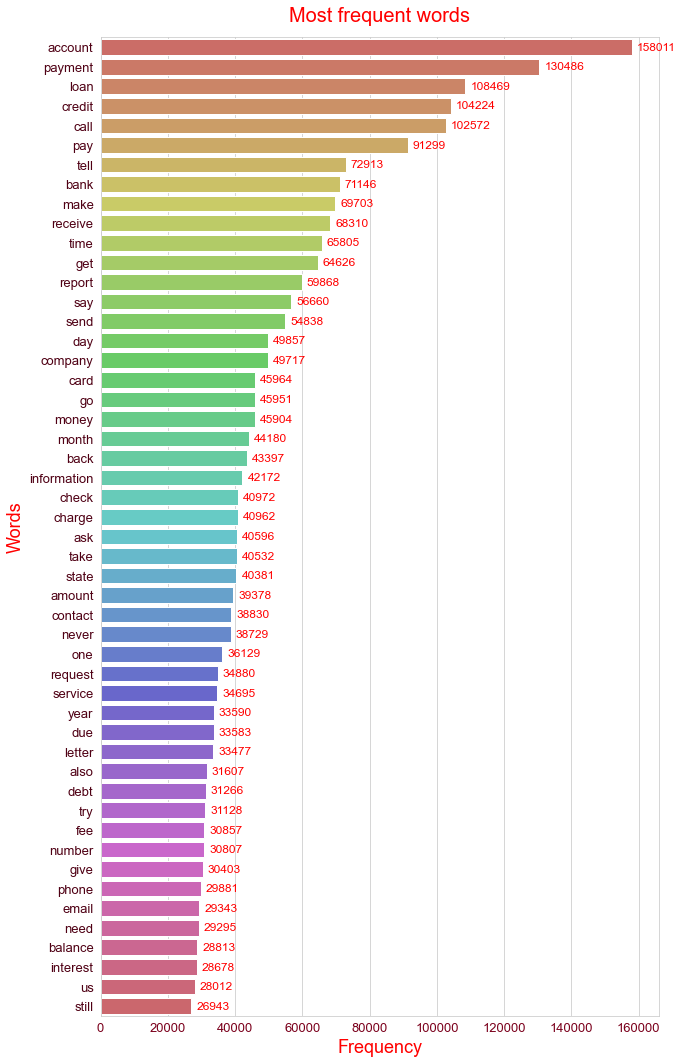

In [13]:
freq_words(data['lemmas'], 50)

Посмотрим на облако слов для каждой категории.

Money transfer, virtual currency, or money service


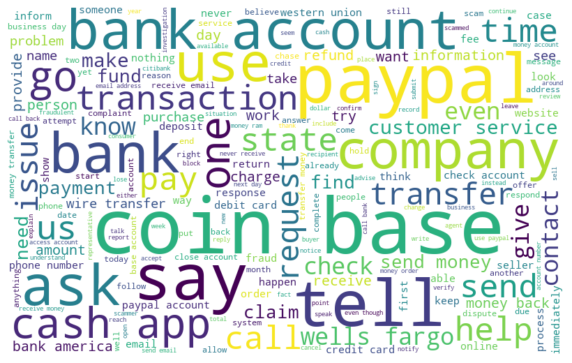

Credit card or prepaid card


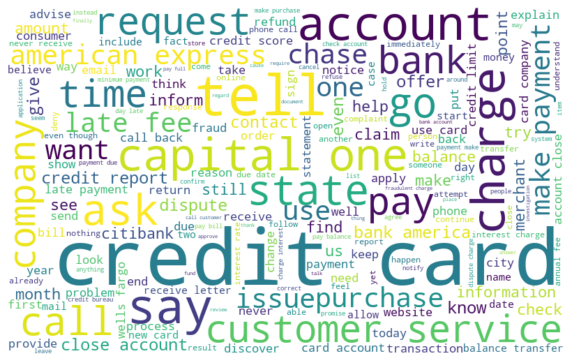

Checking or savings account


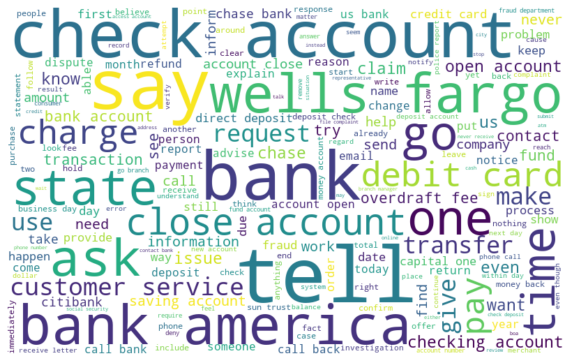

Vehicle loan or lease


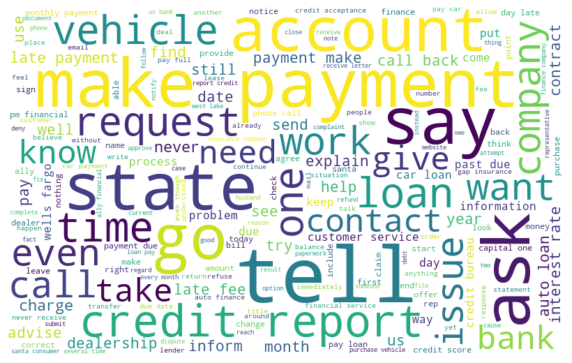

Mortgage


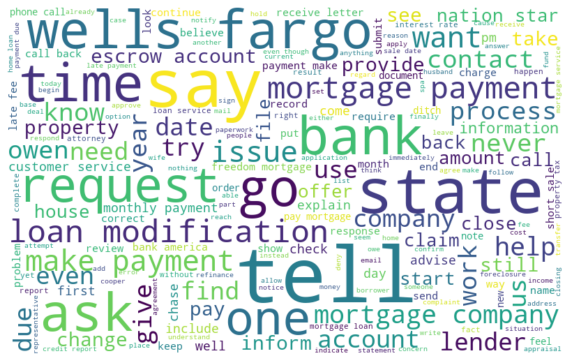

Student loan


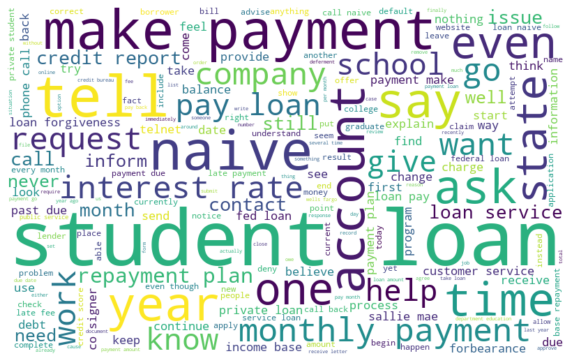

Credit reporting, credit repair services, or other personal consumer reports


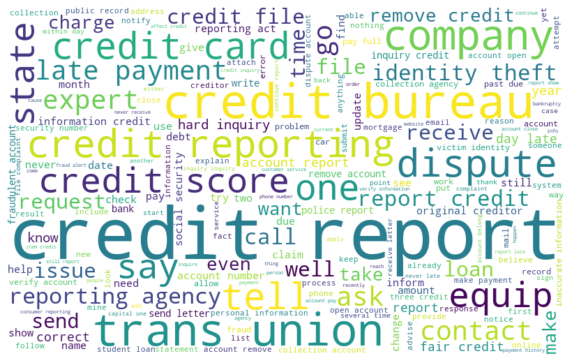

Payday loan, title loan, or personal loan


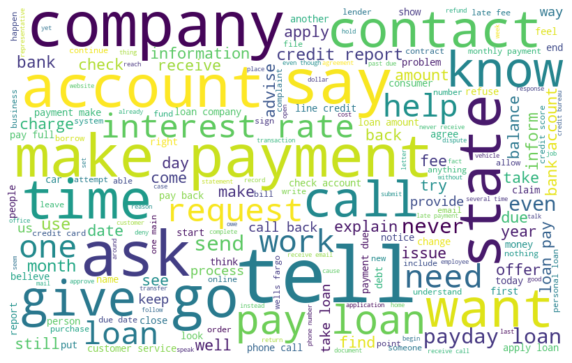

Debt collection


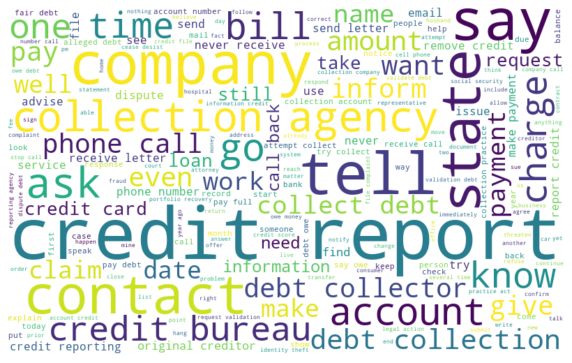

In [14]:
for product_name in data['Product'].unique():
    print(product_name)
    all_words = ' '.join([text for text in data.loc[data['Product'].str.contains(product_name),'lemmas']])
    from wordcloud import WordCloud
    wordcloud = WordCloud(background_color='white', width=800, height=500, 
                          random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()